In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor


df=pd.read_csv('train.csv')
df=df.drop('Id',axis=1)

def comparehists(column,df=df):
    # this will be used to see effect of logging or square rooting
    c=column
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    ax1.set_title('square root')
    ax2.set_title('Normal')
    ax3.set_title('Log')
    sns.histplot(df[c]**0.5,ax=ax1)
    sns.histplot(df[c],ax=ax2)
    sns.histplot(np.log(df[c]),ax=ax3)

### Preprocessing

#### Step1: fix skewness using log

c:\Users\Moataz Imad\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


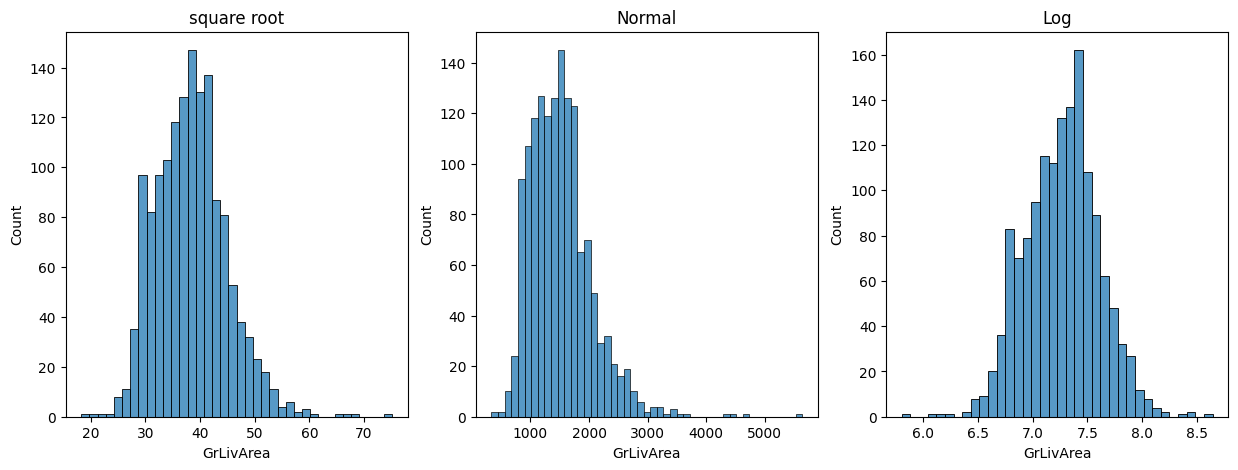

In [9]:

numeric=df.select_dtypes('float64').columns.union(df.select_dtypes('int64').columns).tolist()
sk={}
for id,c in enumerate(numeric):
    sk[id]=[c,skew(df[c]),skew(np.log1p(df[c])),len(df[c].dropna().drop_duplicates())]
skeww=pd.DataFrame.from_dict(sk,orient='index',columns=['column','skew','loged','count_unique'])
# skeww
skeww=skeww[skeww.count_unique>10].sort_values(['count_unique','skew'],ascending=False).head(15)
# extracting columns from above DF, and filtering them by hand (some have no effect/negative effects)

tolog=['LotArea','GrLivArea','1stFlrSF','SalePrice','BsmtFinSF1',
 '2ndFlrSF','WoodDeckSF','OpenPorchSF','BsmtFinSF2','EnclosedPorch']
comparehists(tolog[1])

t=df.copy() # t will have logged values
for col in tolog:
    t[col]=np.log(t[col])
# t.describe()
t.replace([-np.inf],0,inplace=True)

In [10]:
d=t.copy() # based on the loged df, will drop some columns
vals=d.select_dtypes('object').apply(lambda x: len(x.dropna()))
todrop=vals[vals<300].index.tolist() #['Alley', 'PoolQC', 'Fence', 'MiscFeature']
d.drop(todrop,axis=1,inplace=True)
d.columns
# len(t.dropna(axis=1))
# d.isna().sum()[d.isna().sum()>0]
# sns.scatterplot(x=d.MoSold,y=d.SalePrice)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

### Defining X and y

In [11]:
# X=df.copy()
X=t.copy() # t will have logged values
# X=d.copy() # d will have logged values and removed columns
y=X.pop('SalePrice')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# y_train

### Pre-processing
before inserting into the pipeline

### Pipeline

In [26]:
# numeric=df.select_dtypes('float64').columns |df.select_dtypes('int64').columns
numeric=X.select_dtypes('float64').columns.union(X.select_dtypes('int64').columns)
# numeric.union()
categorical=X.select_dtypes('object').columns
RFR=RandomForestRegressor(n_estimators=500)
XGB=XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

numtrans =Pipeline([
    ('imputer',SimpleImputer(missing_values=np.nan,strategy='mean')),
    ('scaler',StandardScaler())
])

cattrans=Pipeline([
   ('imputer', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[('num',numtrans,numeric),
                  ('cat',cattrans,categorical)
])

myModel=Pipeline([
    ('preprocess',preprocessor),
    ('model',XGB)
    # ('model',RFR)
])


myModel.fit(X_train,y_train)



[16:07:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'Gr...
                              feature_types=None, gamma=0.0468, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0,
                              min_child_weight=1.7817, missing=nan,
                              monotone_constraints='()', n_estimators=2200,
                              n_jobs=-1, nthread=-1, num_parallel_tree=1,
                              predictor='auto', ...))])

In [30]:

def giveScore(model,X_test=X_test,y_test=y_test):
    y_pred=model.predict(X_test)
    y_pred
    y_truth= y_test
    diff=abs(y_pred-y_truth)
    percent=diff/y_truth*100
    results=pd.DataFrame({'y_pred':y_pred,'y_truth':y_truth,'diff':diff,'percent':percent})
    print(f'Average % Error ={results.percent.mean()}')
    return results

def giveScorelog(model,X_test=X_test,y_test=y_test):
    y_pred=np.exp(model.predict(X_test))
    y_pred
    y_truth= np.exp(y_test)
    diff=abs(y_pred-y_truth)
    percent=diff/y_truth*100
    results=pd.DataFrame({'y_pred':y_pred,'y_truth':y_truth,'diff':diff,'percent':percent})
    print(f'Average % Error ={results.percent.mean()}')
    return results

# giveScorelog(myModel)
cross_val_score(cv=5,X=X,y=y,n_jobs=5,estimator=myModel)


array([0.92028338, 0.89862526, 0.90467071, 0.92118386, 0.88409348])

### Result if no log was used:

In [192]:

tt=pd.read_csv('test.csv')
pred=myModel.predict(tt)
res=pd.DataFrame({'Id':tt.Id,'SalePrice':pred})
res.to_csv(index=False,path_or_buf='out.csv')

### Result if log was used

In [28]:
tt=pd.read_csv('test.csv')
id=tt.Id
tt.drop('Id',axis=1,inplace=True)
for col in tolog:
    if col!='SalePrice':
        tt[col]=np.log(tt[col])
# t.describe()
tt.replace([-np.inf],0,inplace=True)

pred=np.exp(myModel.predict(tt))
res=pd.DataFrame({'Id':id,'SalePrice':pred})
res.to_csv(index=False,path_or_buf='out.csv')

c:\Users\Moataz Imad\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
dd=tt.copy()
# dd.drop(todrop,axis=1,inplace=True)
pred=np.exp(myModel.predict(dd))
res=pd.DataFrame({'Id':id,'SalePrice':pred})
res.to_csv(index=False,path_or_buf='out.csv')
res.head()

,Id,SalePrice
0,1461,125871.914062
1,1462,154331.390625
2,1463,196133.546875
3,1464,192747.984375
4,1465,179969.390625
